**GeekHub 2018-2019 DL**

**Home work 13 Neural Networks**

Kaggle competion: https://www.kaggle.com/c/geekhub-ds-2019-challenge

Link for collab: https://colab.research.google.com/drive/1IZEyIORa4sDgBkxU9NV-hJLNfZMWMg8u
                            https://colab.research.google.com/drive/1WTWKY0S19cKBKYKuv2_9juTHCNyKSfVv

**Kaggle for colab**

In [0]:
import json

!mkdir .kaggle
token = {"username":"philkaua","key":"4d2727e8a90a45c00bd89a17e5ef6dbe"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [3]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

- path is now set to: {/content}


**Import numpy, keras submodules and some other modules**

In [0]:
import cv2
import kaggle
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import shutil
import tensorflow as tf
import time

from glob import glob

from keras.applications import VGG16, VGG19, ResNet50, InceptionV3, Xception
from keras import datasets, models, callbacks, applications, utils
from keras.callbacks import ModelCheckpoint
from keras import layers, initializers, optimizers, regularizers
from keras.layers import Input, Dropout, Dense, BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from shutil import copy2, move, rmtree

tf.logging.set_verbosity(tf.logging.ERROR)

**Load data from repository**

In [84]:
#!kaggle competitions download -c geekhub-ds-2019-challenge

# shutil.rmtree('train')
# shutil.rmtree('test')
  
# Modified

!wget https://www.dropbox.com/s/x64iwaavbcf8yhc/train.zip
!unzip -q "train.zip"

!wget https://www.dropbox.com/s/jtnsry6zdth4n6t/test.zip
!unzip -q "test.zip"

# Real
# !wget https://www.dropbox.com/s/duzv8x5ddxla7u2/_rain.zip
# !unzip -q "_rain.zip"
# !wget https://www.dropbox.com/s/4fm1xwchxgjdpqa/_est.zip
# !unzip -q "_est.zip"

!wget https://www.dropbox.com/s/ljcgvyjo95ogjs8/train_labels.csv

--2019-04-11 14:25:36--  https://www.dropbox.com/s/x64iwaavbcf8yhc/train.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/x64iwaavbcf8yhc/train.zip [following]
--2019-04-11 14:25:36--  https://www.dropbox.com/s/raw/x64iwaavbcf8yhc/train.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc99196dbcaae69bd42f4e238417.dl.dropboxusercontent.com/cd/0/inline/Ae3M6qVSs4ciA_mzajwrTtm-t11Z0ggyim9xOty4C9_qR7XeFTh0SGwdG__Irt3pFHvhmWyDabTWN1Ydb1NcWaygyS-fBE0FMrMXGN6sOmK0UO7oOdrymQNnogpcP7MlAc4/file# [following]
--2019-04-11 14:25:36--  https://uc99196dbcaae69bd42f4e238417.dl.dropboxusercontent.com/cd/0/inline/Ae3M6qVSs4ciA_mzajwrTtm-t11Z0ggyim9xOty4C9_qR7XeFTh0SGwdG__Irt3pFHvhmWyDabTWN1Ydb1NcWaygyS-fBE0FMrMXGN6sOmK0UO7oOdrymQNnogp

**Data exploration**

In [85]:
# shutil.rmtree('test')
# shutil.rmtree('train')
# shutil.rmtree('data')
# os.remove('test.zip')
# os.remove('train_labels.csv.1')
# os.remove('_est.zip')
# os.remove('_est.zip.1')
# os.remove('_rain.zip')
# os.remove('_rain.zip.1')
!ls

features_train.npy	 test		   train
features_validation.npy  test.zip	   train_labels.csv
new-weights.hdf5	 top-weights.hdf5  train.zip


In [86]:
pd.read_csv('train_labels.csv').head(10)

Id   Category
0   0       rose
1   1  sunflower
2   2      daisy
3   3      daisy
4   4      daisy
5   5      daisy
6   6      tulip
7   7      tulip
8   8  sunflower
9   9      tulip

**File operations - load data**

In [87]:
#Train and Test labels

# File operations
path_to_files_train = 'train/*'
path_to_files_test = 'test/*'

train_csv_file = pd.read_csv('train_labels.csv')['Category']

file_train = [file for file in sorted(glob(path_to_files_train))]
file_test = [file for file in sorted(glob(path_to_files_test))]

# classes
class_names = np.unique(train_csv_file)
class_dict = {class_name:ind for ind, class_name in enumerate(class_names)}

# labels
train_labels = train_csv_file.map(class_dict).values

# categories
categories = list(class_dict.keys())

print(f'Classes:{class_dict}\n')
print(f'Train labels quantity:{train_labels.shape[0]}\n')

print('Quantity in classes:')
for cls, label in class_dict.items():
    print(f'{cls} => {len(np.where(train_labels == label)[0])}')

Classes:{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

Train labels quantity:3026

Quantity in classes:
daisy => 536
dandelion => 743
rose => 569
sunflower => 483
tulip => 695


**Images example**

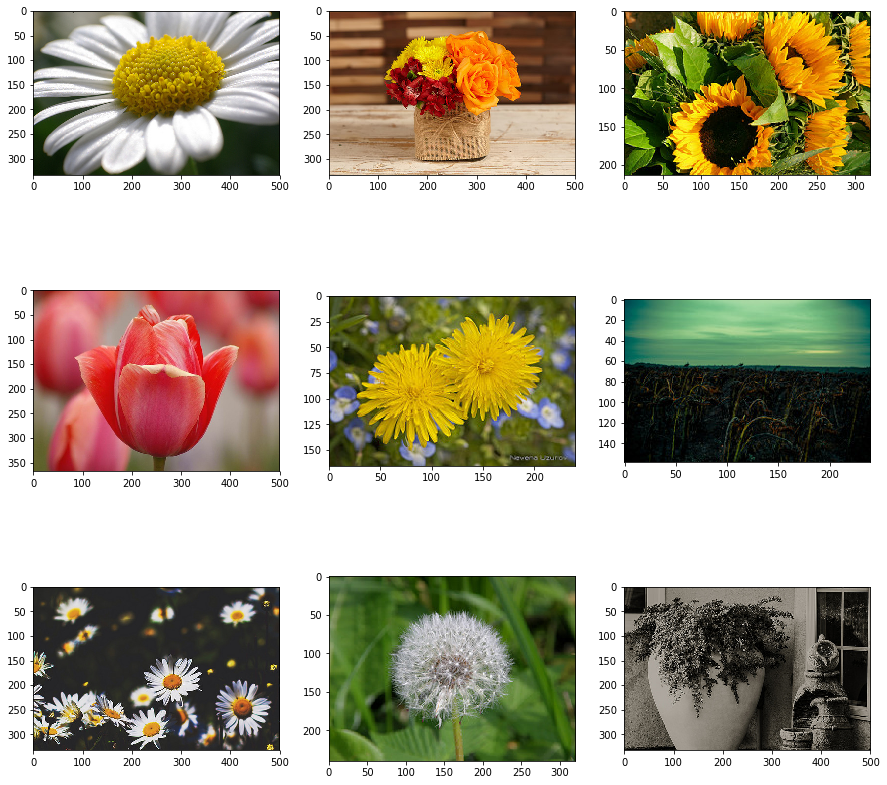

In [89]:
def cvtRGB(img):
    '''convert cv2 BGR format to RGB'''
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))

for i in range(9):
    ax = plt.subplot(3,3,i+1)
    idx = np.random.randint(len(file_train))
    plot_image_tmp = file_train[idx]
    plt.grid(False)
    plt.imshow(cvtRGB(cv2.imread(plot_image_tmp)));

**Shuffle data**

In [0]:
seed = 105
np.random.seed(seed)
np.random.shuffle(file_train)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(file_test)

# **Splitting files for train and test**

In [0]:
np.random.seed(seed)

# X_train_file, X_test_all_file, y_train_file, y_test_all_file = train_test_split(file_train,\
#                                                          train_labels, test_size=0.2, random_state=seed, shuffle=True)
# X_val_file, X_test_file, y_val_file, y_test_file = train_test_split(X_test_all_file,\
#                                                          y_test_all_file, test_size=0.1, random_state=seed, shuffle=True)

X_train_file, X_val_file, y_train_file, y_val_file = train_test_split(file_train,\
                                                            train_labels, test_size=0.15, random_state=seed, stratify=train_labels)

**Path, quantity for train, valid data**

In [96]:
def quantity_in_category(data_path, labels_path):
    ''' create path to labels
    data_path - path to data
    labels_path - path to labels
    '''  
    # quantity for each category
    quantity = [] 
    indcies_labels = [np.where(labels_path == category)[0] for category in class_dict.values()]
      
    for category, labels in zip(categories, indcies_labels):
        quantity.append(labels.shape[0])
        print(f'{category}: {labels.shape[0]}')
    print('')

    path_labels_and_data = [*map(lambda y: [*map(lambda x:data_path[x], y)], indcies_labels)]

    return path_labels_and_data, quantity


labels_path, data_path = y_train_file, X_train_file

print('Train data:')

train_files_path, train_quantity = quantity_in_category(X_train_file, y_train_file)
print('Valid data:')
valid_files_path, valid_quantity = quantity_in_category(X_val_file, y_val_file)
#print('Test data:')
#test_files_path, test_quantity = quantity_in_category(X_test_file, y_test_file)

Train data:
daisy: 456
dandelion: 631
rose: 484
sunflower: 410
tulip: 591

Valid data:
daisy: 80
dandelion: 112
rose: 85
sunflower: 73
tulip: 104



**Copy files to  folders**

In [97]:
# rmtree('data')
# rmtree('test/test_images')

def copy_categoreis(path_category, category, data):
    '''Copy each categories in folder
    path_category - list of path to files
    category - categories in data
    data - str -> train, valid, test'''
    
    folder = 'data/' + data + '/' + category    
        
    # Create folder
    if not os.path.isdir('data'):
        os.makedirs('data')  
    
    if not os.path.isdir(folder):
        os.makedirs(folder)   
    
    # Copy files
    for file in path_category:
        copy2(file, folder)
        print(f'copy file: {file} -> to {folder}')
    
    return print(f'category {category} -> finish \n')  

# Copy train files
for path, category in zip(train_files_path, categories):
     copy_categoreis(path, category, 'train')
# Copy valid files        
for path, category in zip(valid_files_path, categories):
     copy_categoreis(path, category, 'valid')
# Copy test files        
#for path, category in zip(test_files_path, categories):
#     copy_categoreis(path, category, 'test')
    
# Copy submissions file to directory
if not os.path.isdir('test/test_images'):
        os.makedirs('test/test_images')  
for file in file_test:
        copy2(file, 'test/test_images')

copy file: train/1807.jpg -> to data/train/daisy
copy file: train/1817.jpg -> to data/train/daisy
copy file: train/0848.jpg -> to data/train/daisy
copy file: train/0568.jpg -> to data/train/daisy
copy file: train/2127.jpg -> to data/train/daisy
copy file: train/1902.jpg -> to data/train/daisy
copy file: train/2217.jpg -> to data/train/daisy
copy file: train/2530.jpg -> to data/train/daisy
copy file: train/0698.jpg -> to data/train/daisy
copy file: train/2064.jpg -> to data/train/daisy
copy file: train/2564.jpg -> to data/train/daisy
copy file: train/0481.jpg -> to data/train/daisy
copy file: train/0299.jpg -> to data/train/daisy
copy file: train/1095.jpg -> to data/train/daisy
copy file: train/2957.jpg -> to data/train/daisy
copy file: train/2088.jpg -> to data/train/daisy
copy file: train/1458.jpg -> to data/train/daisy
copy file: train/0565.jpg -> to data/train/daisy
copy file: train/2435.jpg -> to data/train/daisy
copy file: train/1096.jpg -> to data/train/daisy
copy file: train/177

In [98]:
!ls data

train  valid


**Load images**

In [100]:
%%time
def load_image(path_categories):
    '''load images by cv2 - categories
    '''
    # Load images by cv2
    images = []
    for files in path_categories:
        images_category = [cvtRGB(cv2.imread(file)) for file in files if (cv2.imread(file)) is not None]
        images.append(images_category)
    return images
  
def cvtRGB(img):
    '''convert cv2 BGR format to RGB'''
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
  
def load_image_out_category(path):
    '''load images by cv2
    '''
    images = []
    for file in path:
        images.append(cvtRGB(cv2.imread(file)))
    return images
  
train_data = load_image(train_files_path)
valid_data = load_image(valid_files_path)
#test_data = load_image(test_files_path)
#submit_data = load_image_out_category(file_test)

CPU times: user 13.8 s, sys: 1.38 s, total: 15.2 s
Wall time: 14.1 s


**Minimal image resolution **

In [102]:
def image_resolution_min(images):
    '''Evaluate image resolution'''
    for category, imgs in zip(categories, images):
        shapes = [img.shape for img in imgs]
        widths = [shape[0] for shape in shapes]
        heights = [shape[1] for shape in shapes]
        print(f'{np.min(widths)},{np.min(heights)} -> min size for {category}')

print('\nTrain data')
image_resolution_min(train_data)
print('\nValid data')
image_resolution_min(valid_data)
#print('\nTest data')
#image_resolution_min(test_data)


Train data
134,134 -> min size for daisy
120,159 -> min size for dandelion
80,150 -> min size for rose
134,159 -> min size for sunflower
134,134 -> min size for tulip

Valid data
125,134 -> min size for daisy
123,146 -> min size for dandelion
134,159 -> min size for rose
159,159 -> min size for sunflower
134,134 -> min size for tulip


**Plot some samples**

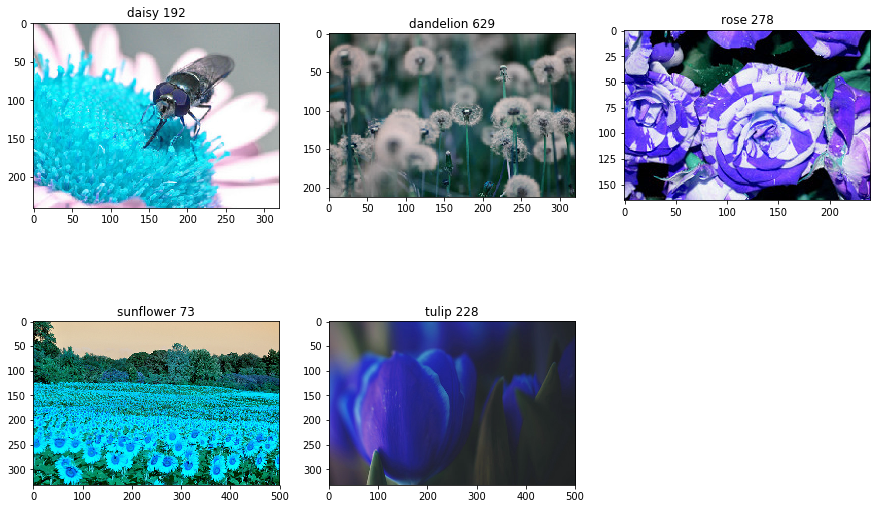

In [103]:
def cvtRGB(img):
    '''convert cv2 BGR format to RGB'''
    #cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
for i, imgs in enumerate(train_data):
    plt.subplot(3,3,i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(cvtRGB(imgs[idx]))
    plt.grid(False)
    plt.title(categories[i] + ' ' + str(idx))
plt.show()

**Resize** all the images (only example)

original shape: (240, 240, 3)
resized shape: (299, 299, 3)


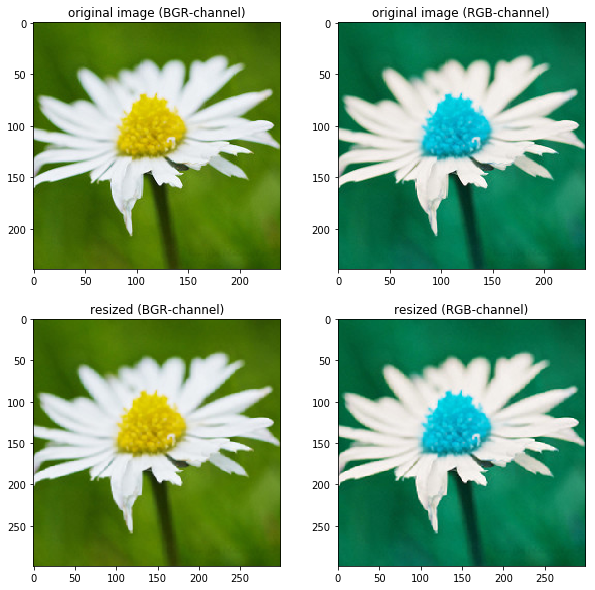

In [60]:
img_width, img_height = 299, 299

img = train_data[0][8]
print(f'original shape: {img.shape}')
resized_img = cv2.resize(img, (img_width, img_height))
resized_img2 = cv2.resize(img,(img_width, img_height), interpolation = cv2.INTER_CUBIC)
print(f'resized shape: {resized_img.shape}')
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('original image (BGR-channel)')
plt.grid(False)
plt.imshow(img)
plt.subplot(2,2,2)
plt.title('original image (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(img))
plt.subplot(2,2,3)
plt.title('resized (BGR-channel)')
plt.grid(False)
plt.imshow((resized_img))
plt.subplot(2,2,4)
plt.title('resized (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(resized_img2))
plt.show()

**Image input data**

In [0]:
# Image forders
train_dir = 'data/train/'
valid_dir = 'data/valid/'
test_dir = 'data/test/'
# Image size
img_width, img_height = 299, 299
# Shape data
input_shape = (img_width, img_height, 3)
# Batch size
batch_size = 16
# Quantity images for train
nb_train_samples = len(X_train_file)
# Quantity images for valid
nb_validation_samples = len(X_val_file)
# Quantity images for test
#nb_test_samples = len(X_test_file)

**Load prediction model**

In [105]:
%%time

from keras.applications.xception import preprocess_input

base_model = applications.Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

#data_generator = ImageDataGenerator(rescale=1. / 255)
data_generator = ImageDataGenerator(zoom_range=0.5, 
                                   rotation_range=45,
                                   width_shift_range=0.5, 
                                   height_shift_range=0.4, 
                                   shear_range=0.4, 
                                   horizontal_flip=True, 
                                   vertical_flip=True, 
                                   fill_mode='nearest',
                                   preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# train
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

features_train = base_model.predict_generator(
        train_generator, 
        nb_train_samples // batch_size + 1)

print('Prediction of the training set finished')

np.save(open('features_train.npy', 'wb'),
            features_train)

# valid
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

features_validation = base_model.predict_generator(
        validation_generator, 
        nb_validation_samples // batch_size + 1)

print('Prediction of the validation set finished')

np.save(open('features_validation.npy', 'wb'),
            features_validation)

Found 2572 images belonging to 5 classes.
Prediction of the training set finished
Found 454 images belonging to 5 classes.
Prediction of the validation set finished
CPU times: user 2min 31s, sys: 27.2 s, total: 2min 58s
Wall time: 1min 57s


In [0]:
base_model.summary()

**Load trained data**

In [0]:
#train
train_data = np.load(open('features_train.npy', 'rb'))
train_labels = np.array(np.sum([([ind] * quantity) for ind, quantity in enumerate(train_quantity)]))
#valid
validation_data = np.load(open('features_validation.npy', 'rb'))
validation_labels = np.array(np.sum([([ind] * quantity) for ind, quantity in enumerate(valid_quantity)]))

**Top layers of base model**

In [107]:
%%time

model = Sequential()
model.add(Dense(2048, activation='relu', input_shape=base_model.output_shape[1:]))
model.add(Dropout(0.1))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer=optimizers.SGD(lr=0.005, momentum=0.1, nesterov=True),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='top-weights.hdf5', verbose=1, save_best_only=True)
reduceLR = callbacks.ReduceLROnPlateau(patience=2, verbose=1)
earlyStop = callbacks.EarlyStopping(patience=4, verbose=1)

model.fit(train_data,
                    train_labels,
                    epochs=100,
                    batch_size=batch_size,
                    callbacks=[checkpointer, reduceLR, earlyStop],
                    validation_data=(validation_data, validation_labels))

Train on 2572 samples, validate on 454 samples
Epoch 1/100
2572/2572 [==============================] - 14s 6ms/step - loss: 1.3361 - acc: 0.5455 - val_loss: 1.0170 - val_acc: 0.7379

Epoch 00001: val_loss improved from inf to 1.01695, saving model to top-weights.hdf5
Epoch 2/100
2572/2572 [==============================] - 2s 751us/step - loss: 0.9479 - acc: 0.7061 - val_loss: 0.7550 - val_acc: 0.7687

Epoch 00002: val_loss improved from 1.01695 to 0.75500, saving model to top-weights.hdf5
Epoch 3/100
2572/2572 [==============================] - 2s 762us/step - loss: 0.7598 - acc: 0.7543 - val_loss: 0.5815 - val_acc: 0.8436

Epoch 00003: val_loss improved from 0.75500 to 0.58154, saving model to top-weights.hdf5
Epoch 4/100
2572/2572 [==============================] - 2s 761us/step - loss: 0.6582 - acc: 0.7741 - val_loss: 0.5226 - val_acc: 0.8414

Epoch 00004: val_loss improved from 0.58154 to 0.52261, saving model to top-weights.hdf5
Epoch 5/100
2572/2572 [===========================

**Main model**

In [113]:
%%time

batch_size = 16
epochs = 25

input_tensor = Input(shape=(img_height,img_width,3))

base_model = applications.Xception(weights='imagenet',
                                            include_top=False,
                                            input_shape=(img_width, img_height, 3),
                                            pooling='avg')

top_model = Sequential()
    
top_model.add(Dense(2048, activation='elu', input_shape=base_model.output_shape[1:]))
top_model.add(Dropout(0.5))

top_model.add(Dense(1024, activation='elu'))
top_model.add(Dropout(0.5))  

top_model.add(Dense(5, activation='softmax'))

top_model.load_weights('top-weights.hdf5')

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

model.compile(optimizer=SGD(lr=0.005, momentum=0.1, nesterov=True),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train_datagen = image.ImageDataGenerator(
#         rescale=1./255,
#         rotation_range=40,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         preprocessing_function = preprocess_input)

# # train_datagen = ImageDataGenerator(rescale=1. / 255,
# #                                   rotation_range=40,
# #                                   width_shift_range=0.2,
# #                                   height_shift_range=0.2,
# #                                   zoom_range=0.2,
# #                                   horizontal_flip=True,
# #                                   fill_mode='nearest')
# #train_datagen.fit(train_data_resized, augment=True)

# valid_datagen = image.ImageDataGenerator(rescale=1./255, preprocessing_function = preprocess_input)

train_datagen = ImageDataGenerator(zoom_range=0.5, 
                                   rotation_range=45,
                                   width_shift_range=0.5, 
                                   height_shift_range=0.4, 
                                   shear_range=0.4, 
                                   horizontal_flip=True, 
                                   vertical_flip=True, 
                                   fill_mode='nearest',
                                   preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse')

checkpointer = ModelCheckpoint(filepath='new-weights.hdf5', verbose=1, save_best_only=True)
reduceLR = callbacks.ReduceLROnPlateau(patience=4, verbose=1)
earlyStop = callbacks.EarlyStopping(patience=5, verbose=1)

model.fit_generator(train_generator,
                    steps_per_epoch=nb_train_samples // batch_size +1,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size +1,
                    epochs=epochs,
                    callbacks=[checkpointer, earlyStop])


Found 2572 images belonging to 5 classes.
Found 454 images belonging to 5 classes.
Epoch 1/25
161/161 [==============================] - 238s 1s/step - loss: 0.7567 - acc: 0.7336 - val_loss: 0.3313 - val_acc: 0.8722

Epoch 00001: val_loss improved from inf to 0.33127, saving model to new-weights.hdf5
Epoch 2/25
161/161 [==============================] - 219s 1s/step - loss: 0.5118 - acc: 0.8166 - val_loss: 0.2849 - val_acc: 0.8965

Epoch 00002: val_loss improved from 0.33127 to 0.28487, saving model to new-weights.hdf5
Epoch 3/25
161/161 [==============================] - 219s 1s/step - loss: 0.4520 - acc: 0.8393 - val_loss: 0.2626 - val_acc: 0.9097

Epoch 00003: val_loss improved from 0.28487 to 0.26264, saving model to new-weights.hdf5
Epoch 4/25
161/161 [==============================] - 219s 1s/step - loss: 0.3825 - acc: 0.8586 - val_loss: 0.2516 - val_acc: 0.9141

Epoch 00004: val_loss improved from 0.26264 to 0.25156, saving model to new-weights.hdf5
Epoch 5/25
161/161 [=========

**Test generator**

In [0]:
# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='sparse',
#     shuffle=False)

# model.evaluate_generator(test_generator, batch_size)

Found 122 images belonging to 5 classes.


[0.10110607863113773, 0.9426229508196722]

**Submission**

In [114]:
# Submission generator

submission_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

#submission_data_generator = ImageDataGenerator(rescale=1./255, preprocessing_function = preprocess_input)

submission_generator = submission_data_generator.flow_from_directory(
    directory="test",
    color_mode="rgb",
    target_size=(299, 299),
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=105)

Found 1297 images belonging to 1 classes.


In [115]:
# rezet generator
submission_generator.reset()
pred=model.predict_generator(submission_generator, steps = 1297, verbose=1)

1297/1297 [==============================] - 54s 42ms/step


In [117]:
# predict classes
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames = pd.Series(submission_generator.filenames).apply(lambda x: x[12:-4])
results=pd.DataFrame({"Id":filenames,
                      "Category":predictions})
results = results[['Id','Category']]
results.to_csv('submission.csv', index=False)
results.head(5)

Id   Category
0  3026      tulip
1  3027       rose
2  3028  dandelion
3  3029  dandelion
4  3030  dandelion

In [118]:
!kaggle competitions submit -c geekhub-ds-2019-challenge -f submission.csv -m "69 preprocess + argument"

100% 15.9k/15.9k [00:00<00:00, 61.6kB/s]
Successfully submitted to GeekHub DS 2019 Challenge

**Predict image**

In [0]:
# classes for predictions
class_dict_reverse = {v:k for k, v in class_dict.items()}

def predict_image(path_img, model):
    '''predict one image by model
    path_img - path to the image
    model - model for prediction
    '''
    img = cvtRGB(cv2.imread(path_img))
    img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)
    img = np.reshape(img, (1, img_width, img_height, 3))
    img = img / 255.
    new_img = model.predict(img)
    class_predict = np.argmax(new_img)
    return class_dict_reverse[class_predict], np.max(new_img) 

**Image plot**

Class: sunflower   probability: 1.000


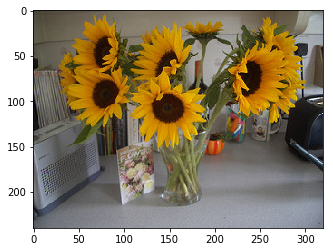

In [120]:
index_image = np.random.randint(len(file_test))
plot_image = file_test[index_image]

predict, probability = predict_image(plot_image, model)
col, axs = plt.subplots(1)

print(f'Class: {predict}   probability: {probability:.3f}')

plt.grid(False)
plt.imshow(cvtRGB(cv2.imread(plot_image)));

Multi plot

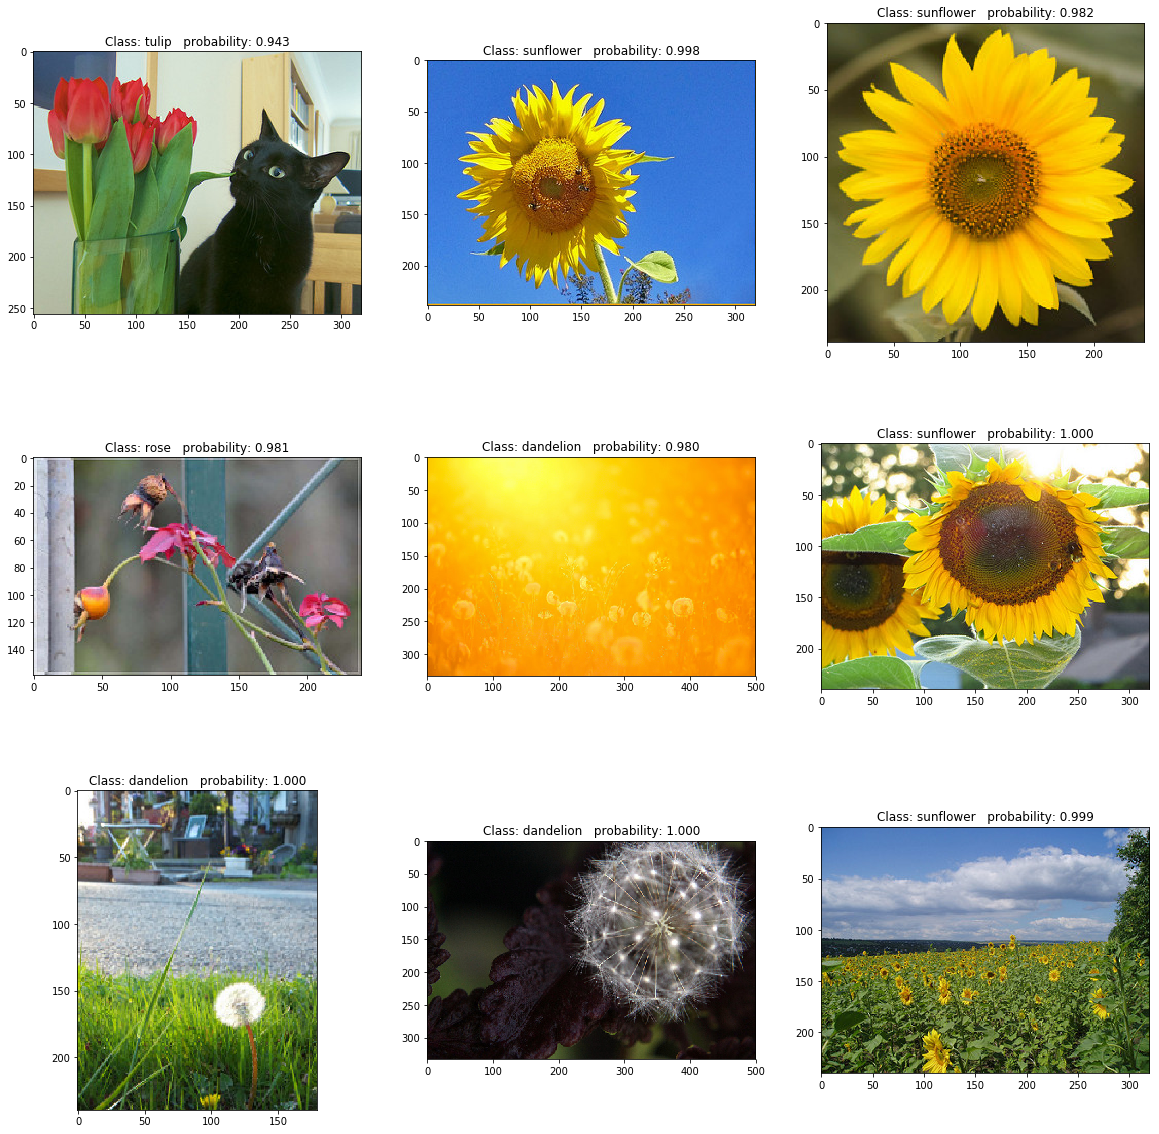

In [121]:
plt.figure(figsize=(20,20))

for i in range(9):
     
    ax = plt.subplot(3,3,i+1)
    
    idx = np.random.randint(len(file_test))
    
    plot_image_tmp = file_test[idx]
    
    predict_, probability_ = predict_image(plot_image_tmp, model)
  
    plt.title(f'Class: {predict_}   probability: {probability_:.3f}')
     
    plt.grid(False)
    
    plt.imshow(cvtRGB(cv2.imread(plot_image_tmp)));

**Low accurassy for predict**

**test images**

In [122]:
%%time
test_predict = [(file, predict_image(file, model)) for file in file_test[:1290]]

CPU times: user 43.1 s, sys: 17.4 s, total: 1min
Wall time: 54.2 s


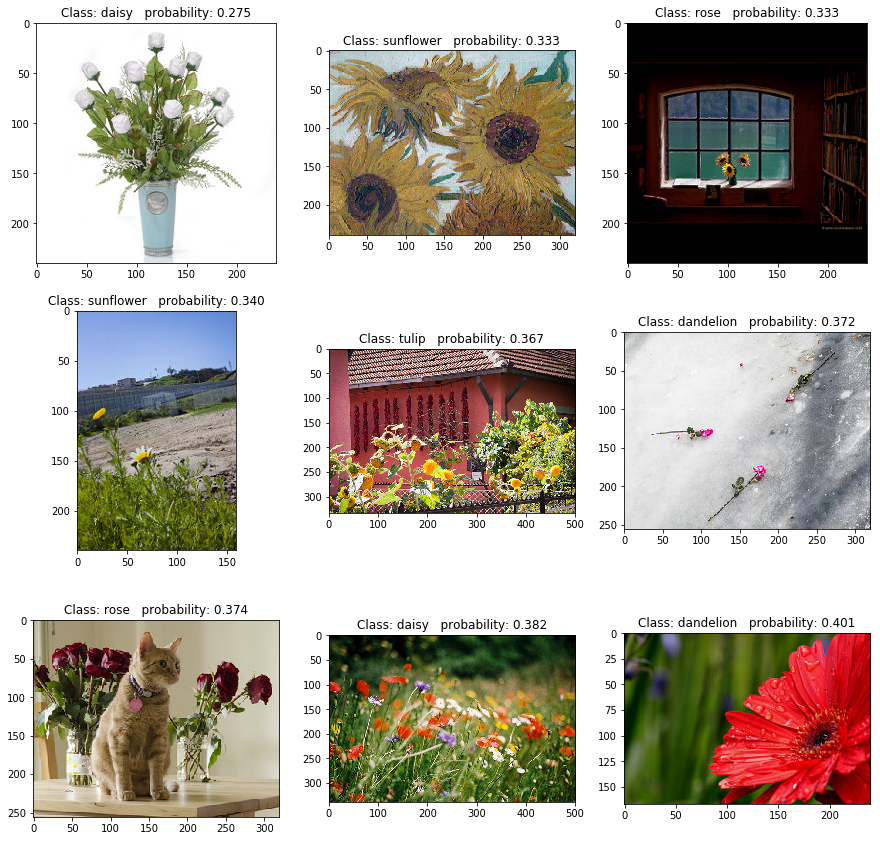

In [123]:
low_acc_predict_class_test = sorted(test_predict, key=lambda x:x[1][1])

plt.figure(figsize=(15,15))

for i in range(9):
     
    ax = plt.subplot(3,3,i+1)
    
    idx = low_acc_predict_class_test[i][0]
    
    predict_, probability_ = predict_image(idx, model)
  
    plt.title(f'Class: {predict_}   probability: {probability_:.3f}')
     
    plt.grid(False)
    
    plt.imshow(cvtRGB(cv2.imread(idx)));

In [125]:
# less than 50% probability
[print(im) for im in low_acc_predict_class_test if im[1][1] < 0.75];

('test/4008.jpg', ('daisy', 0.27472097))
('test/3804.jpg', ('sunflower', 0.33322945))
('test/4267.jpg', ('rose', 0.33324188))
('test/3701.jpg', ('sunflower', 0.34008113))
('test/3198.jpg', ('tulip', 0.3669292))
('test/3732.jpg', ('dandelion', 0.37185484))
('test/3976.jpg', ('rose', 0.37377518))
('test/4251.jpg', ('daisy', 0.38203683))
('test/3806.jpg', ('dandelion', 0.40104747))
('test/4050.jpg', ('dandelion', 0.4032025))
('test/3861.jpg', ('tulip', 0.4033841))
('test/3836.jpg', ('tulip', 0.4264287))
('test/4163.jpg', ('dandelion', 0.431618))
('test/3566.jpg', ('sunflower', 0.44622377))
('test/3174.jpg', ('rose', 0.4474518))
('test/3199.jpg', ('rose', 0.44975457))
('test/4257.jpg', ('sunflower', 0.45841897))
('test/3892.jpg', ('sunflower', 0.46580088))
('test/3735.jpg', ('dandelion', 0.4692277))
('test/3800.jpg', ('rose', 0.4730301))
('test/3151.jpg', ('tulip', 0.4761612))
('test/3263.jpg', ('rose', 0.48736152))
('test/4222.jpg', ('rose', 0.48751822))
('test/3862.jpg', ('rose', 0.48974

**train images**

In [126]:
%%time
train_predict = [(file, predict_image(file, model)) for file in file_train]

CPU times: user 1min 43s, sys: 40.3 s, total: 2min 23s
Wall time: 2min 8s


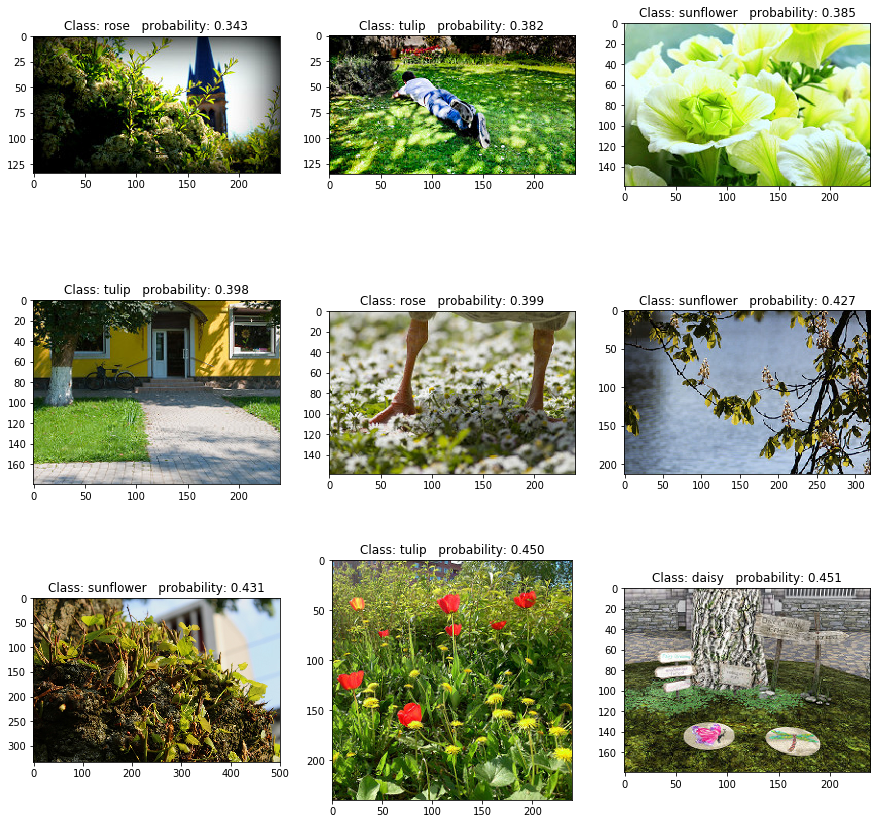

In [127]:
low_acc_predict_class_train = sorted(train_predict, key=lambda x:x[1][1])

plt.figure(figsize=(15,15))

for i in range(9):
     
    ax = plt.subplot(3,3,i+1)
    
    idx = low_acc_predict_class_train[i][0]
    
    predict_, probability_ = predict_image(idx, model)
  
    plt.title(f'Class: {predict_}   probability: {probability_:.3f}')
     
    plt.grid(False)
    
    plt.imshow(cvtRGB(cv2.imread(idx)));

In [0]:
# less than 75% probability
#[print(im) for im in low_acc_predict_class_train if im[1][1] < 0.75]
bad_images = [im[0] for im in low_acc_predict_class_train if im[1][1] < 0.75]

**Plotting Learning Curves**

In [0]:
# graphics data
val_acc_data = model.history.history['val_acc']
val_loss_data = model.history.history['val_loss']
acc_data = model.history.history['acc']
loss_data = model.history.history['loss']
epoch_data = model.history.epoch

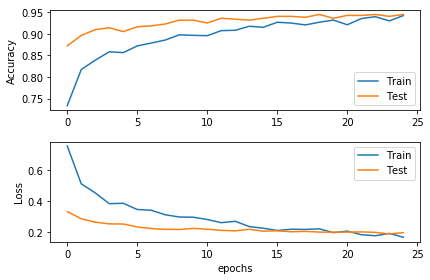

In [133]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(epoch_data, acc_data, epoch_data, val_acc_data)

axs[0].set_ylabel('Accuracy')

axs[1].plot(epoch_data, loss_data, epoch_data, val_loss_data)
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('epochs')

axs[0].legend(('Train', 'Test'), loc="best")
axs[1].legend(('Train', 'Test'), loc="best")

fig.tight_layout()
plt.show()


**Load  file names and labels again and delete bad images**

In [177]:
train_csv_file = pd.read_csv('train_labels.csv')['Category']

file_train = [file for file in sorted(glob(path_to_files_train))]
file_test = [file for file in sorted(glob(path_to_files_test))]

# classes
class_names = np.unique(train_csv_file)
class_dict = {class_name:ind for ind, class_name in enumerate(class_names)}

# labels
train_labels = train_csv_file.map(class_dict).values

# Delete bad images
out_bad_lables_images = [(lable, file) for lable, file in zip(train_labels, file_train) if file not in bad_images]

print('Quantity of delete images:',len(file_train) - len(out_bad_lables_images))

Quantity of delete images: 132


**Shuffle**

In [0]:
seed = 105
np.random.seed(seed)
np.random.shuffle(out_bad_lables_images)

new_file_train = list( map(lambda x: x[1], out_bad_lables_images) )
new_train_labels = list( map(lambda x: x[0], out_bad_lables_images) )

**Split data**

In [0]:
np.random.seed(seed)

X_train_file, X_val_file, y_train_file, y_val_file = train_test_split(new_file_train,\
                                                            new_train_labels, test_size=0.15, random_state=seed, stratify=new_train_labels)

**Path to data && Quantity**

In [207]:
def quantity_in_category(data_path, labels_path):
    ''' create path to labels
    data_path - path to data
    labels_path - path to labels
    '''  
    # quantity for each category
    quantity = [] 
    indcies_labels = [np.where(np.array(labels_path) == category)[0] for category in class_dict.values()]
      
    for category, labels in zip(categories, indcies_labels):
        quantity.append(labels.shape[0])
        print(f'{category}: {labels.shape[0]}')
    print('')

    path_labels_and_data = [*map(lambda y: [*map(lambda x:data_path[x], y)], indcies_labels)]

    return path_labels_and_data, quantity


print('Train data:')
train_files_path, train_quantity = quantity_in_category(X_train_file, y_train_file)

print('Valid data:')
valid_files_path, valid_quantity = quantity_in_category(X_val_file, y_val_file)

Train data:
daisy: 439
dandelion: 612
rose: 446
sunflower: 399
tulip: 563

Valid data:
daisy: 78
dandelion: 108
rose: 79
sunflower: 71
tulip: 99



**Copy files**

In [0]:
# rmtree('_ata')
# rmtree('test/test_images')

def copy_categoreis_modify(path_category, category, data):
    '''Copy each categories in folder
    path_category - list of path to files
    category - categories in data
    data - str -> train, valid, test'''
    
    folder = '_ata/' + data + '/' + category    
        
    # Create folder
    if not os.path.isdir('_ata'):
        os.makedirs('_ata')  
    
    if not os.path.isdir(folder):
        os.makedirs(folder)   
    
    # Copy files
    for file in path_category:
        copy2(file, folder)
        print(f'copy file: {file} -> to {folder}')
    
    return print(f'category {category} -> finish \n')  

# Copy train files
for path, category in zip(train_files_path, categories):
     copy_categoreis_modify(path, category, 'train')
# Copy valid files        
for path, category in zip(valid_files_path, categories):
     copy_categoreis_modify(path, category, 'valid')

**Input image data**

In [0]:
# Image forders
train_dir = '_ata/train/'
valid_dir = '_ata/valid/'
# Image size
img_width, img_height = 299, 299
# Shape data
input_shape = (img_width, img_height, 3)
# Batch size
batch_size = 16
# Quantity images for train
nb_train_samples = len(X_train_file)
# Quantity images for valid
nb_validation_samples = len(X_val_file)

**Predict model**

In [210]:
%%time

from keras.applications.xception import preprocess_input

base_model = applications.Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

#data_generator = ImageDataGenerator(rescale=1. / 255)
data_generator = ImageDataGenerator(zoom_range=0.5, 
                                   rotation_range=45,
                                   width_shift_range=0.5, 
                                   height_shift_range=0.4, 
                                   shear_range=0.4, 
                                   horizontal_flip=True, 
                                   vertical_flip=True, 
                                   fill_mode='nearest',
                                   preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# train
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

features_train = base_model.predict_generator(
        train_generator, 
        nb_train_samples // batch_size + 1)

print('Prediction of the training set finished')

np.save(open('features_train.npy', 'wb'),
            features_train)

# valid
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

features_validation = base_model.predict_generator(
        validation_generator, 
        nb_validation_samples // batch_size + 1)

print('Prediction of the validation set finished')

np.save(open('features_validation.npy', 'wb'),
            features_validation)

Found 2459 images belonging to 5 classes.
Prediction of the training set finished
Found 435 images belonging to 5 classes.
Prediction of the validation set finished
CPU times: user 2min 33s, sys: 26.2 s, total: 2min 59s
Wall time: 2min


**Load data after train**

In [0]:
#train
train_data = np.load(open('features_train.npy', 'rb'))
train_labels = np.array(np.sum([([ind] * quantity) for ind, quantity in enumerate(train_quantity)]))
#valid
validation_data = np.load(open('features_validation.npy', 'rb'))
validation_labels = np.array(np.sum([([ind] * quantity) for ind, quantity in enumerate(valid_quantity)]))

**Top layres train**

In [212]:
%%time

model = Sequential()
model.add(Dense(2048, activation='relu', input_shape=base_model.output_shape[1:]))
model.add(Dropout(0.1))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer=optimizers.SGD(lr=0.005, momentum=0.1, nesterov=True),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='top-weights.hdf5', verbose=1, save_best_only=True)
reduceLR = callbacks.ReduceLROnPlateau(patience=2, verbose=1)
earlyStop = callbacks.EarlyStopping(patience=4, verbose=1)

model.fit(train_data,
                    train_labels,
                    epochs=100,
                    batch_size=batch_size,
                    callbacks=[checkpointer, reduceLR, earlyStop],
                    validation_data=(validation_data, validation_labels))

Train on 2459 samples, validate on 435 samples
Epoch 1/100
2459/2459 [==============================] - 19s 8ms/step - loss: 1.3187 - acc: 0.5445 - val_loss: 0.9882 - val_acc: 0.7586

Epoch 00001: val_loss improved from inf to 0.98822, saving model to top-weights.hdf5
Epoch 2/100
2459/2459 [==============================] - 2s 823us/step - loss: 0.9176 - acc: 0.7198 - val_loss: 0.7110 - val_acc: 0.7954

Epoch 00002: val_loss improved from 0.98822 to 0.71097, saving model to top-weights.hdf5
Epoch 3/100
2459/2459 [==============================] - 2s 818us/step - loss: 0.7260 - acc: 0.7601 - val_loss: 0.5722 - val_acc: 0.8253

Epoch 00003: val_loss improved from 0.71097 to 0.57222, saving model to top-weights.hdf5
Epoch 4/100
2459/2459 [==============================] - 2s 828us/step - loss: 0.6238 - acc: 0.7853 - val_loss: 0.5038 - val_acc: 0.8529

Epoch 00004: val_loss improved from 0.57222 to 0.50379, saving model to top-weights.hdf5
Epoch 5/100
2459/2459 [===========================

**Main model**

In [213]:
%%time

batch_size = 16
epochs = 25

input_tensor = Input(shape=(img_height,img_width,3))

base_model = applications.Xception(weights='imagenet',
                                            include_top=False,
                                            input_shape=(img_width, img_height, 3),
                                            pooling='avg')

top_model = Sequential()
    
top_model.add(Dense(2048, activation='relu', input_shape=base_model.output_shape[1:]))
top_model.add(Dropout(0.5))

top_model.add(Dense(1024, activation='relu'))
top_model.add(Dropout(0.5))  

top_model.add(Dense(5, activation='softmax'))

top_model.load_weights('top-weights.hdf5')

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

model.compile(optimizer=SGD(lr=0.005, momentum=0.1, nesterov=True),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train_datagen = image.ImageDataGenerator(
#         rescale=1./255,
#         rotation_range=40,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         preprocessing_function = preprocess_input)

# # train_datagen = ImageDataGenerator(rescale=1. / 255,
# #                                   rotation_range=40,
# #                                   width_shift_range=0.2,
# #                                   height_shift_range=0.2,
# #                                   zoom_range=0.2,
# #                                   horizontal_flip=True,
# #                                   fill_mode='nearest')
# #train_datagen.fit(train_data_resized, augment=True)

# valid_datagen = image.ImageDataGenerator(rescale=1./255, preprocessing_function = preprocess_input)

train_datagen = ImageDataGenerator(zoom_range=0.5, 
                                   rotation_range=45,
                                   width_shift_range=0.5, 
                                   height_shift_range=0.4, 
                                   shear_range=0.4, 
                                   horizontal_flip=True, 
                                   vertical_flip=True, 
                                   fill_mode='nearest',
                                   preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse')

checkpointer = ModelCheckpoint(filepath='del-new-weights.hdf5', verbose=1, save_best_only=True)
reduceLR = callbacks.ReduceLROnPlateau(patience=4, verbose=1)
earlyStop = callbacks.EarlyStopping(patience=5, verbose=1)

model.fit_generator(train_generator,
                    steps_per_epoch=nb_train_samples // batch_size +1,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size +1,
                    epochs=epochs,
                    callbacks=[checkpointer, earlyStop])

Found 2459 images belonging to 5 classes.
Found 435 images belonging to 5 classes.
Epoch 1/25
154/154 [==============================] - 236s 2s/step - loss: 0.6805 - acc: 0.7437 - val_loss: 0.2436 - val_acc: 0.9218

Epoch 00001: val_loss improved from inf to 0.24362, saving model to del-new-weights.hdf5
Epoch 2/25
154/154 [==============================] - 207s 1s/step - loss: 0.5044 - acc: 0.8123 - val_loss: 0.2157 - val_acc: 0.9241

Epoch 00002: val_loss improved from 0.24362 to 0.21566, saving model to del-new-weights.hdf5
Epoch 3/25
154/154 [==============================] - 207s 1s/step - loss: 0.4127 - acc: 0.8497 - val_loss: 0.1906 - val_acc: 0.9264

Epoch 00003: val_loss improved from 0.21566 to 0.19057, saving model to del-new-weights.hdf5
Epoch 4/25
154/154 [==============================] - 208s 1s/step - loss: 0.3835 - acc: 0.8644 - val_loss: 0.1659 - val_acc: 0.9402

Epoch 00004: val_loss improved from 0.19057 to 0.16591, saving model to del-new-weights.hdf5
Epoch 5/25
15

**Submission**

In [214]:
# Submission generator

submission_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

#submission_data_generator = ImageDataGenerator(rescale=1./255, preprocessing_function = preprocess_input)

submission_generator = submission_data_generator.flow_from_directory(
    directory="test",
    color_mode="rgb",
    target_size=(299, 299),
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=105)

# rezet generator
submission_generator.reset()
pred=model.predict_generator(submission_generator, steps = 1297, verbose=1)

Found 1297 images belonging to 1 classes.
1297/1297 [==============================] - 57s 44ms/step


In [215]:
# predict classes
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames = pd.Series(submission_generator.filenames).apply(lambda x: x[12:-4])
results=pd.DataFrame({"Id":filenames,
                      "Category":predictions})
results = results[['Id','Category']]
results.to_csv('submission.csv', index=False)
results.head(5)

Id   Category
0  3026      tulip
1  3027       rose
2  3028  dandelion
3  3029  dandelion
4  3030  dandelion

In [216]:
!kaggle competitions submit -c geekhub-ds-2019-challenge -f submission.csv -m "70 preprocess + argument + del bad images"

100% 15.9k/15.9k [00:00<00:00, 44.4kB/s]
Successfully submitted to GeekHub DS 2019 Challenge